In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201

from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D

tf.__version__

'2.3.1'

# Data

## Load data

**data is structured as:**   
   
       ../data/
            multiclass_200/
                train/
                    Aloe_Vera/
                        Aloe_Vera_1.jpeg
                        Aloe_Vera_2.jpeg
                        ...
                    ...
                    Umbrella_Tree/
                        Umbrella_Tree_1.jpeg
                        Umbrella_Tree_2.jpeg
                        ...
                test/
                    Aloe_Vera/
                        Aloe_Vera_1.jpeg
                        Aloe_Vera_2.jpeg
                        ...
                    ...
                    Umbrella_Tree/
                        Umbrella_Tree_1.jpeg
                        Umbrella_Tree_2.jpeg
                        ...
                val/
                    Aloe_Vera/
                        Aloe_Vera_1.jpeg
                        Aloe_Vera_2.jpeg
                        ...
                    ...
                    Umbrella_Tree/
                        Umbrella_Tree_1.jpeg
                        Umbrella_Tree_2.jpeg
                        ...
            House_Plants.csv
    
    
**split-folders (pip install split-folders) can be used to help with train/test/val splitting**

**Define dataset location and desired size:**

In [2]:
data_path = '../data/multiclass_3c_x_200i/'
batch_size = 32
img_height = 240
img_width = 240

## Load data

In [3]:
# 80% training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# 20% validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 600 files belonging to 3 classes.
Using 480 files for training.
Found 600 files belonging to 3 classes.
Using 120 files for validation.


**List classes**

In [4]:
class_names = train_ds.class_names
no_classes = len(class_names)
print(class_names)

['Aloe_Vera', 'Boston_Fern', 'Fiddle_Leaf_Fig']


## Visualize raw data

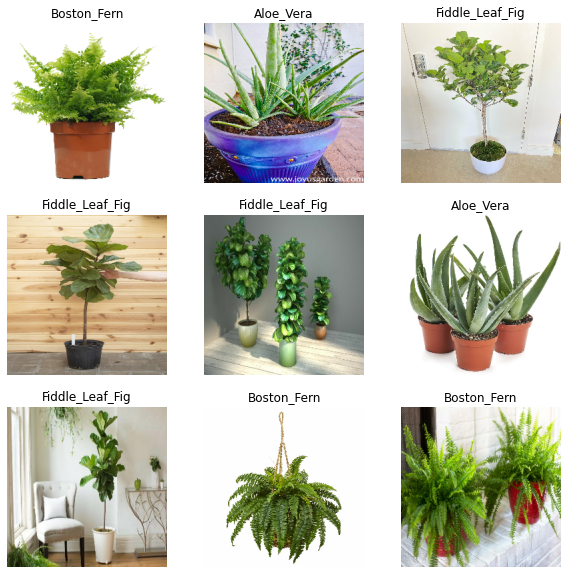

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Preprocess the data
randomly applying changes like zooms, rotations and flips help the neural network to be more generalizable.
These can be applied most efficiently within a layer of the network but here they are applied as a preprocessing step.

**Define pre-processing pipeline**

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomRotation(0.5),
    layers.experimental.preprocessing.RandomZoom(0.1), # zoom in and out <10%
#     layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
])

# could add brightness shifts, lateral/vertical shifts, and shearing

**Apply pre-processing**

In [7]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

## Visualize pre-processed dataset

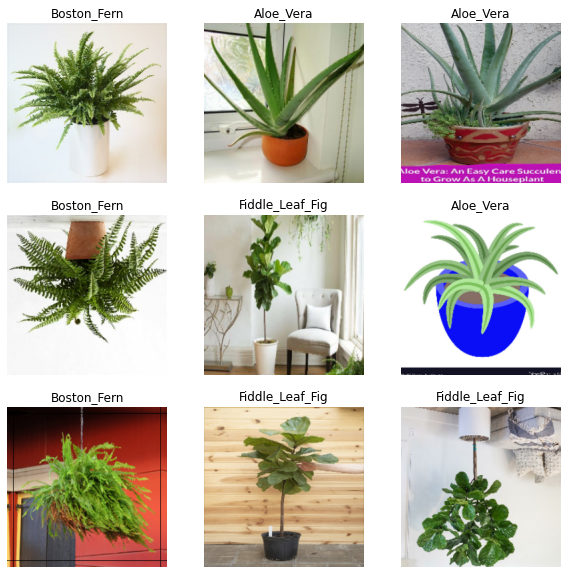

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Prefetch the data

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Build model

In [17]:
IMG_SHAPE = (img_height, img_width, 3)

# resize_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))

# create the base model from the pre-trained model VGG16
# note that, if using a Kaggle server, internet has to be turned on
pretrained_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')

# freeze the convolutional base
pretrained_model.trainable = False

model = tf.keras.Sequential([#resize_layer,
                             pretrained_model,
                             GlobalAveragePooling2D(),
                             Dense(256, activation='tanh'),
                             Dense(256, activation='tanh'),
                             Dropout(0.5, name='drop_fc1'),
                             Dense(no_classes, activation='softmax')])

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
drop_fc1 (Dropout)           (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 14,912,579
Trainable params: 197,891
Non-trainable params: 14,714,688
____________________________________

# Train model

In [20]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


ValueError: in user code:

    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /opt/miniconda3/envs/tf23/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_vals = np.arange(1, epochs+1)

print(x_vals, acc)

ax[0].plot(x_vals, acc, '+-', label='training')
ax[0].plot(x_vals, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_vals, loss, '+-', label='training')
ax[1].plot(x_vals, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()